# Predicting Depression among Students

__________________________
**Tags:** *Machine Learning*, *Binary Classification*, *Predictive Analysis*, *Descriptive Analysis*

**Techniques**: *Imputation*, *Scaling*, *OneHotEncoding*, *Cross Validation*

**Python:** *Scikit-Learn*, *Pandas*, *Matplotlib*, *Seaborn* (see below for full list)
__________________________

__________________________
**Scenario:** A large university wants to proactively support student mental health through targeted interventions. 
They have surveyed 28,000 students in order to gain insights about which factors are likely contributing to depression. In the process, an early-warning system should be implemented. Students who fill out the survey in the future should receive a statistical prediction of their depression status, so they can seek help if needed. Our role is to develop such a statistical ML model.


**Goal:** We want to build a Machine Learning model that predicts a student's depression status *True (1)* or *False (0)*. For this purpose, we are going to explore and describe the data and build a binary classifier using state-of-the-art Python packages. In the process, we hope to learn something new about the disease from the model. 


**Dataset:** We are given a (toy) dataset containing a list of students and their demographics, lifestyle habits, academic performance, and depression status. The dataset is taken from Kaggle. Author: Shodolamu Opeyemi, Title: "Student Depression Dataset.", https://www.kaggle.com/datasets/hopesb/student-depression-dataset

__________________________

__________________________
## Contents

1. **Preliminary considerations**
<p> </p>
2. **Exploring and cleaning the data**
<p> </p>
3. **Selecting and building models**
<p> </p>
4. **Evaluating the models**
__________________________

__________________________
# 1. Preliminary considerations

### 1.1 Legal and ethical considerations
In this notebook, we are dealing with fake data. In a real setting, the above scenario raises issues of ethical and legal concern. As data scientists, we are responsible for ethical data manipulation that adheres to legal standards, like the [GDPR in the European Union](https://eur-lex.europa.eu/eli/reg/2016/679/oj/eng). Under the GDPR framework, parts of this dataset would be considered sensitive data, which carries legal implications in how the data is obtained, handled and distributed.

### 1.2 Performance measure
Under the given scenario, we are going to measure our model performance by setting aside a test set and comparing the results of our model candidates, leading to a confusion matrix. We will prefer the Precision-Recall (PR) curve over the Receiver Operating Characteristic (ROC) curve. This is because we would like to maximize the number of true positives, a false positive is not as bad as a false negative. In other words, accidentally suggesting a depression-free student to seek counselling is better than failing to give such a recommendation to a student with an actual depression.

### 1.3 Model candidates and general plan
To keep this demonstration simple, we will consider only two models of the Scikit Package: *Logistic Regression* and *Decision Tree Classifier*. We want to cross-validate them on a validation set and tune their parameters, before we finalize the model development and evaluate its performance on the test set.
__________________________

# 2. Exploring and cleaning the data

### Relevant packages used throughout this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## 2.1 Data Exploration

In [2]:
df = pd.read_csv('Depression Prediction Dataset.csv') #available here: https://www.kaggle.com/datasets/hopesb/student-depression-dataset
df.shape

(27901, 18)

Let us first get a broad overview of the dataset.

In [3]:
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


For each instance, that is a unique student, we are given 18 features, including a unique ID and the target variable 'Depression'. The feature types are of categorical, ordinal and numerical nature. The following data types are used in the dataframe:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

The dataset contains a list of about 28,000 students, which is fairly small for Machine Learning techniques. As we imported a CSV file, we know the object values are all text attributes. Moreover we can see that a few values are missing in the #15 'Financial Stress' feature. We will deal with this problem later. For now, let us further explore the numerical features.

In [5]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


For now, the data does not seem too extraordinary. A few points to consider:

* As a kind of sanity check, at least 75 per cent of the people are 30 or younger, which is what we would expect from a dataset containing students.
<p> <br> </p>
* Something is going on with the work pressure and job satisfaction features: there are at least 75 per cent of zero values given in these features.
<p> <br> </p>
* 58.5 per cent of the surveyed students are suffering from depression. This value seems relatively high compared to the general population, so in a real setting, we would have to inquire where such a high prevalence is coming from.

In [6]:
df.describe(include=object)

,Gender,City,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,27901,27901,27901,27901,27901,27901,27901,27901
unique,2,52,14,5,4,28,2,2
top,Male,Kalyan,Student,Less than 5 hours,Unhealthy,Class 12,Yes,No
freq,15547,1570,27870,8310,10317,6080,17656,14398


Let us list all occuring values of the categorical features, like so:

In [7]:
for feature in df.select_dtypes(include=object):
    print(feature)
    print(df[feature].unique(), '\n')

Gender
['Male' 'Female'] 

City
['Visakhapatnam' 'Bangalore' 'Srinagar' 'Varanasi' 'Jaipur' 'Pune' 'Thane'
 'Chennai' 'Nagpur' 'Nashik' 'Vadodara' 'Kalyan' 'Rajkot' 'Ahmedabad'
 'Kolkata' 'Mumbai' 'Lucknow' 'Indore' 'Surat' 'Ludhiana' 'Bhopal'
 'Meerut' 'Agra' 'Ghaziabad' 'Hyderabad' 'Vasai-Virar' 'Kanpur' 'Patna'
 'Faridabad' 'Delhi' 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'City' '3.0'
 'Less than 5 Kalyan' 'Mira' 'Harsha' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kibara' 'Rashi' 'ME' 'M.Com' 'Nalyan' 'Mihir' 'Nalini' 'Nandini'
 'Khaziabad'] 

Profession
['Student' 'Civil Engineer' 'Architect' 'UX/UI Designer'
 'Digital Marketer' 'Content Writer' 'Educational Consultant' 'Teacher'
 'Manager' 'Chef' 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist'] 

Sleep Duration
['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours' 'Others'] 

Dietary Habits
['Healthy' 'Moderate' 'Unhealthy' 'Others'] 

Degree
['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 

Clearly, there are a few irregularities present, however we will not worry about them right now. 

In a real scenario, this would be a good moment to create a test set and put it aside for now, lest we recognize patterns that could possibly lead to bias in our model selection. Before evaluating our model, we would only work with the training data. To keep the code simple, we instead clean the whole dataset at once and only split them into training set and test set afterwards.

Let us plot some useful variables in histograms:

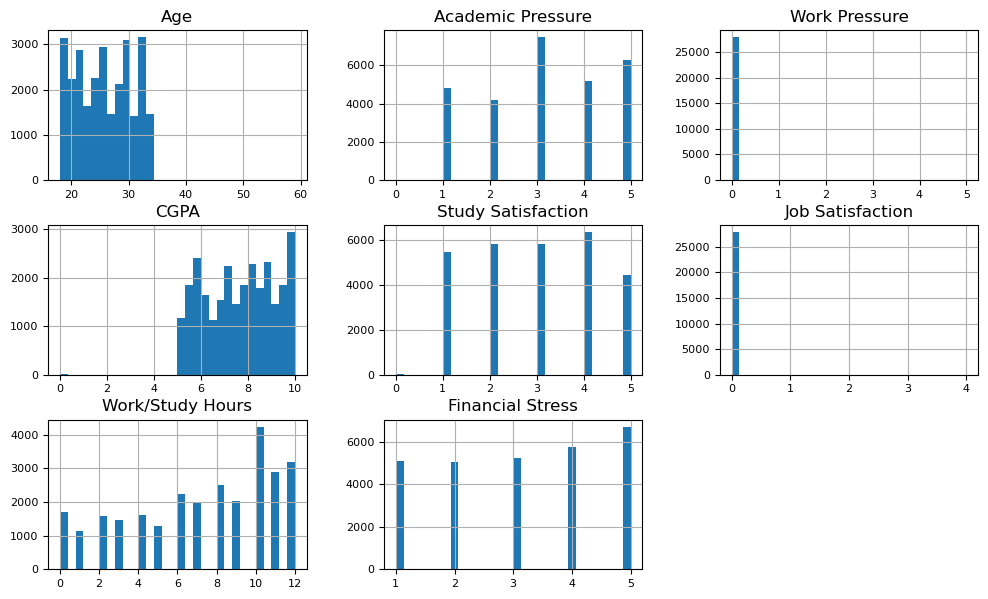

In [8]:
#selecting relevant features
hist_columns = [2, 5, 6, 7, 8, 9, 14, 15]

#formatting the plots
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

#plotting
df.iloc[:, hist_columns].hist(bins=30, figsize=(12,7))
plt.show()

Let us now try to find simple correlations by creating some fancy plots.

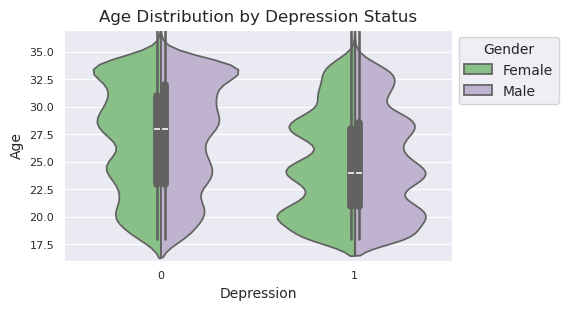

In [9]:
sns.set_style('darkgrid')

plt.figure(figsize=(5,3))
g = sns.violinplot(data=df, x='Depression', y='Age', hue='Gender', split=True, palette="Accent")
g.set(title='Age Distribution by Depression Status', ylim=[16,37])
g.legend(title='Gender', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

From this graph we can observe that students with depression are generally younger than people without. This holds across all genders.

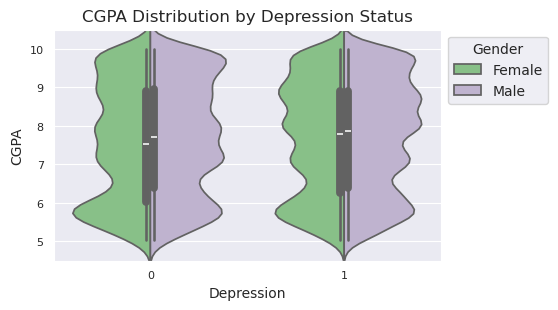

In [10]:
plt.figure(figsize=(5,3))
g = sns.violinplot(data=df, x='Depression', y='CGPA', hue='Gender', split=True, palette="Accent")
g.set(title='CGPA Distribution by Depression Status', ylim=[4.5,10.5])
g.legend(title='Gender', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The *CGPA* feature looks about identically distributed across students with and without depression, likewise across all genders.

In [11]:
pd.crosstab(index=[df['Depression'], df['Gender']], columns=df['Study Satisfaction'])

Study Satisfaction  0.0   1.0   2.0   3.0   4.0   5.0
Depression Gender                                    
0          Female     2   740   964   986  1376  1065
           Male       2   854  1106  1482  1719  1269
1          Female     3  1611  1674  1484  1445  1004
           Male       3  2246  2094  1869  1819  1084

Maybe unsurprisingly, depressed students are much more unsatisfied with their studies. Again, this is true for all genders.

In [12]:
pd.crosstab(index=[df['Depression'], df['Gender']], columns=df['Financial Stress'])

Financial Stress    1.0   2.0   3.0   4.0   5.0
Depression Gender                              
0          Female  1539  1276   930   814   573
           Male    1950  1610  1216   971   684
1          Female   729   949  1362  1722  2458
           Male     903  1226  1718  2268  3000

What is also not surprising is that higher financial stress seems to correlate positively with depression.

In [13]:
df.loc[df['Sleep Duration'].isin(['7-8 hours', 'More than 8 hours']), 'Sleep_Cat'] = 'At least 7 hours'
df.loc[df['Sleep Duration'].isin(['5-6 hours', 'Less than 5 hours']), 'Sleep_Cat'] = 'At most 6 hours'
df = df.drop('Sleep Duration', axis=1)

pd.crosstab(index=[df['Depression']], columns=df['Sleep_Cat'])

Sleep_Cat,At least 7 hours,At most 6 hours,nan
Depression,,,
0,5941,5615,9
1,7449,8878,9


While a long sleep duration of more than 8 hours may not correlate strongly with depression status, a short sleep duration of less than 5 hours does lead to higher depression rates.

By plotting the features, we can easily observe some more irregularities in the data:

* *Age* and *CGPA* values have some outliers outside a range wherein most values lie. Likewise, there are a few zero values in the *Academic Pressure* and *Study Satisfaction* features which we have to deal with.
<p> </p>
* As we have suspected, features *Work Pressure* and *Job Satisfaction* are fundamentally flawed, consisting mostly of the same value (= 0). We will verify this once more by listing all non-zero values. (If there would have been more instances of non-zero values, leading to a massively long list, computing percentiles would also have been an option.)

In [14]:
workpressure = df['Work Pressure']
workpressure[workpressure>0]

4365     5.0
14855    2.0
25746    5.0
Name: Work Pressure, dtype: float64

In [15]:
jobsatisfaction = df['Job Satisfaction']
jobsatisfaction[jobsatisfaction>0]

292      3.0
4365     4.0
13909    2.0
14855    1.0
20913    1.0
23141    2.0
25746    4.0
26719    2.0
Name: Job Satisfaction, dtype: float64

* Let us do something similar for the CGPA. Putting our strongest magnifying lens to use, we can spot a few zero values in this histogram, though most of the values seem to begin around 5. Our evaluation confirms this this suspicion: although it shows a value of 5.03, students are probably evaluated between 5 and 10 in this particular CGPA system.

In [16]:
cgpa = df['CGPA']
min(cgpa[cgpa>0])

5.03

* Furthermore, we can easily locate the invisible age line in the boxplot. It must be somewhere between 30 and 40, so by trying a few values, we find the line to be at 35 years. Only 49 students are at least 35 years old.

In [17]:
ages = df['Age']
len(ages[ages>=35])

49

Finally, let us get a glance of the categorical variables. 

In [18]:
categorical = [1, 3, 4, 10, 11, 12, 13, 16]
df.iloc[:, categorical].describe(include='object')

,Gender,City,Profession,Dietary Habits,Degree,Have you ever had suicidal thoughts ?
count,27901,27901,27901,27901,27901,27901
unique,2,52,14,4,28,2
top,Male,Kalyan,Student,Unhealthy,Class 12,Yes
freq,15547,1570,27870,10317,6080,17656


We notice that there are no unfilled values, and the features are self-explanatory. Now, let us identify the most frequent values for each feature.

In [19]:
for col in categorical:
    print('variable:', df.columns[col])
    print(df.loc[col].value_counts()[:5])
    print("\n")

variable: Gender
1
0.0       3
2.0       2
8         1
Female    1
24.0      1
Name: count, dtype: int64


variable: City
3
0.0       2
Yes       2
30        1
Female    1
28.0      1
Name: count, dtype: int64


variable: Profession
4
0.0       3
1.0       2
32        1
Female    1
25.0      1
Name: count, dtype: int64


variable: Dietary Habits
10
3.0    2
0.0    2
Yes    2
1.0    2
83     1
Name: count, dtype: int64


variable: Degree
11
0.0     3
Yes     2
91      1
Male    1
33.0    1
Name: count, dtype: int64


variable: Have you ever had suicidal thoughts ?
12
1.0     3
0.0     2
94      1
Male    1
27.0    1
Name: count, dtype: int64


variable: Work/Study Hours
13
0.0       3
2.0       2
100       1
Female    1
19.0      1
Name: count, dtype: int64


variable: Depression
16
5.0    2
0.0    2
2.0    2
Yes    2
120    1
Name: count, dtype: int64




The data looks plausible. We notice that the dataset consists mostly of students from Indian cities, of which there are slightly more males than females. Additionally, there are some rare values in the features *Profession*, *Sleep Duration* and *Dietary Habits*.

## 2.2 Dataset Cleaning

Let us summarize the *Degree* feature into more useful categories: High School diploma, Bachelor degree, Master degree, PhD. This will be stored in a new feature called *Degree_Cat*. The old feature column will be dropped.

In [20]:
df['Degree'].unique()

array(['B.Pharm', 'BSc', 'BA', 'BCA', 'M.Tech', 'PhD', 'Class 12', 'B.Ed',
       'LLB', 'BE', 'M.Ed', 'MSc', 'BHM', 'M.Pharm', 'MCA', 'MA', 'B.Com',
       'MD', 'MBA', 'MBBS', 'M.Com', 'B.Arch', 'LLM', 'B.Tech', 'BBA',
       'ME', 'MHM', 'Others'], dtype=object)

In [21]:
bachelor = ['B.Pharm', 'BSc', 'BA', 'BCA', 'B.Ed', 'LLB', 'BE', 'BHM', 'B.Com', 'B.Arch', 'B.Tech', 'BBA']
master = ['M.Tech', 'M.Ed', 'MSc', 'M.Pharm', 'MCA', 'MA',  'MD', 'MBA', 'MBBS', 'M.Com', 'LLM', 'ME', 'MHM']

df.loc[df['Degree'] == 'PhD', 'Degree_Cat'] = 'PhD'
df.loc[df['Degree'].isin(master), 'Degree_Cat'] = 'Master'
df.loc[df['Degree'].isin(bachelor), 'Degree_Cat'] = 'Bachelor'
df.loc[df['Degree'] == 'Class 12', 'Degree_Cat'] = 'High School'

In [22]:
df = df[df['Degree_Cat'] != "nan"]
df = df.drop('Degree', axis=1)
df['Degree_Cat'].value_counts().sort_index()

Degree_Cat
Bachelor       12639
High School     6080
Master          8625
PhD              522
Name: count, dtype: int64

Let us codify the binary features into classic boolean values.

In [23]:
df = df.rename(columns={'Have you ever had suicidal thoughts ?': 'Thoughts'})
df['Thoughts'] = df['Thoughts'].replace("Yes", 1)
df['Thoughts'] = df['Thoughts'].replace("No", 0)
df['Thoughts'].value_counts()

Thoughts
1    17636
0    10230
Name: count, dtype: int64

In [24]:
df = df.rename(columns={'Family History of Mental Illness': 'Family History'})
df['Family History'] = df['Family History'].replace("Yes", 1)
df['Family History'] = df['Family History'].replace("No", 0)
df['Family History'].value_counts()

Family History
0    14379
1    13487
Name: count, dtype: int64

In [25]:
df = df.rename(columns={'Gender': 'Female'})
df['Female'] = df['Female'].replace("Female", 1)
df['Female'] = df['Female'].replace("Male", 0)
df['Female'].value_counts()

Female
0    15528
1    12338
Name: count, dtype: int64

In [26]:
df['Sleep_Cat'] = df['Sleep_Cat'].replace("At least 7 hours", 1)
df['Sleep_Cat'] = df['Sleep_Cat'].replace("At most 6 hours", 0)
df['Sleep_Cat'].value_counts()

Sleep_Cat
0      14476
1      13372
nan       18
Name: count, dtype: int64

Now we will deal with instances with at least one rare attribute. For the *Age* feature, since most values lie between 18 and 35 years, we will assign all values above 35 to this new maximum. By doing so, we do not have to delete any additional instances. For features *Academic Pressure* and *Study Satisfaction*, a similar approach is not plausible, hence we drop the outliers.

In [27]:
df.loc[df['Age'] >= 35.0, 'Age'] = 35.0
df = df.drop(df[df['Study Satisfaction'] == 0.0].index)
df = df.drop(df[df['Academic Pressure'] == 0.0].index)
df = df.drop(df[df['CGPA'] < 5.0].index)
df = df.drop(df[df['Dietary Habits'] == "Others"].index)

Let us have a more thorough look at the cities:

In [28]:
cities = df['City'].value_counts()
cities

City
Kalyan                1569
Srinagar              1369
Hyderabad             1339
Vasai-Virar           1288
Lucknow               1152
Thane                 1139
Ludhiana              1111
Agra                  1093
Surat                 1078
Kolkata               1059
Jaipur                1035
Patna                 1003
Visakhapatnam          968
Pune                   966
Ahmedabad              945
Bhopal                 931
Chennai                884
Meerut                 823
Rajkot                 813
Delhi                  768
Bangalore              766
Ghaziabad              742
Mumbai                 696
Vadodara               690
Varanasi               683
Nagpur                 649
Indore                 642
Kanpur                 608
Nashik                 546
Faridabad              459
Saanvi                   2
Bhavna                   2
City                     2
Harsha                   2
Kibara                   1
Nandini                  1
Nalini                 

We can expect cities to have a significant influence to a person's depression status, so in general we would like to keep as much information as possible. Let us ask ChatGPT to produce a Python-like list of all Indian cities with at least 1 million and at least 100,000 inhabitants. This is the result:

In [29]:
cities_1M = ["Mumbai", "Delhi", "Bangalore", "Hyderabad", "Ahmedabad", "Chennai", "Kolkata", "Surat", "Pune", "Jaipur", "Lucknow", "Kanpur", "Nagpur", "Visakhapatnam", "Indore", "Vadodara", "Coimbatore", "Madurai", "Rajkot", "Bhopal", "Thane", "Chandigarh"]
cities_100k = ["Agra", "Ajmer", "Akola", "Aligarh", "Ambala", "Amritsar", "Asansol", "Aurangabad", "Bhilai", "Bhiwandi", "Bilaspur", "Bokaro", "Chandrapur", "Dhanbad", "Dewas", "Gaya", "Ghaziabad", "Gorakhpur", "Gulbarga", "Guwahati", "Haldia", "Haridwar", "Hassan", "Howrah", "Hubli-Dharwad", "Jabalpur", "Jaunpur", "Jhansi", "Jodhpur", "Kochi", "Kolkata", "Korba", "Kottayam", "Kurnool", "Mangalore", "Meerut",
               "Moradabad", "Nagapattinam", "Nanded", "Nashik", "Navi Mumbai", "Nellore", "Patiala", "Ranchi", "Rohtak", "Shivpuri", "Solapur", "Tirunelveli", "Udaipur", "Ujjain", "Vijayawada", "Warangal"]

In order to limit the number of values, let us only keep this information for the *City* feature:

In [30]:
df.loc[df['City'].isin(cities_1M), 'City_Cat'] = '1M'
df.loc[df['City'].isin(cities_100k), 'City_Cat'] = '100k'
df.loc[~(df['City'].isin(cities_1M) | df['City'].isin(cities_100k)), 'City_Cat'] = 'Rest'
df['City_Cat'].value_counts()

City_Cat
1M      16069
Rest     7508
100k     4263
Name: count, dtype: int64

Let us delete the non-values at *Sleep_Cat*.

In [31]:
df['Sleep_Cat'] = df['Sleep_Cat'].replace("nan", np.nan)
df = df.dropna(subset='Sleep_Cat')

Afterwards, all columns with only one attribute will be dropped. We do not need them anymore.

In [32]:
cols_to_drop = ['Profession', 'Work Pressure', 'City', 'Job Satisfaction']
df = df.drop(cols_to_drop, axis=1)
df.describe()

,id,Female,Age,Academic Pressure,CGPA,Study Satisfaction,Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Sleep_Cat
count,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27819.000000,27822.000000,27822.000000,27822.000000
mean,70455.628172,0.442779,25.809719,3.142405,7.659012,2.944540,0.632773,7.160485,3.139797,0.484149,0.585544,0.480339
std,40644.411018,0.496724,4.872652,1.380748,1.464334,1.360208,0.482058,3.706285,1.437225,0.499758,0.492637,0.499622
min,2.000000,0.000000,18.000000,1.000000,5.030000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,35055.000000,0.000000,21.000000,2.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000
50%,70720.500000,0.000000,25.000000,3.000000,7.770000,3.000000,1.000000,8.000000,3.000000,0.000000,1.000000,0.000000
75%,105829.500000,1.000000,30.000000,4.000000,8.920000,4.000000,1.000000,10.000000,4.000000,1.000000,1.000000,1.000000
max,140699.000000,1.000000,35.000000,5.000000,10.000000,5.000000,1.000000,12.000000,5.000000,1.000000,1.000000,1.000000


## 2.3 Data Scaling, One-Hot Encoding and Data Imputation

We will rescale the remaining features into the unit interval *[0, 1]* so that all features are in the same range. This can be achieved by the MinMaxScaler provided by Scikit-Learn.

In [33]:
scaler = MinMaxScaler()
cols_to_scale = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours', 'Financial Stress']

for col in cols_to_scale:
    data = df.loc[:, col:col]
    df[col] = scaler.fit_transform(data)

df.describe()

,id,Female,Age,Academic Pressure,CGPA,Study Satisfaction,Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Sleep_Cat
count,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27822.000000,27819.000000,27822.000000,27822.000000,27822.000000
mean,70455.628172,0.442779,0.459395,0.535601,0.528976,0.486135,0.632773,0.596707,0.534949,0.484149,0.585544,0.480339
std,40644.411018,0.496724,0.286627,0.345187,0.294635,0.340052,0.482058,0.308857,0.359306,0.499758,0.492637,0.499622
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35055.000000,0.000000,0.176471,0.250000,0.253521,0.250000,0.000000,0.333333,0.250000,0.000000,0.000000,0.000000
50%,70720.500000,0.000000,0.411765,0.500000,0.551308,0.500000,1.000000,0.666667,0.500000,0.000000,1.000000,0.000000
75%,105829.500000,1.000000,0.705882,0.750000,0.782696,0.750000,1.000000,0.833333,0.750000,1.000000,1.000000,1.000000
max,140699.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


What about the remaining features?

In [34]:
df.describe(include=object)

,Dietary Habits,Degree_Cat,City_Cat
count,27822,27822,27822
unique,3,4,3
top,Unhealthy,Bachelor,1M
freq,10287,12620,16060


The latter three features are of ordinal nature. We could convert them into numbers and rescale them into the unit interval. However by doing so, we are implicitly assuming that the spacings between two values are equidistant (i.e., the leap between a high school diploma and a Bachelor's degree is equal to the leap between a Master's degree and a PhD degree, or improving one's Financial Stress by one point is always equally important). These assumptions have been much more reasonable in the cases above. Though we are losing a bit of information (the ordering), we will leave these features as is and treat them like the other categorical variable *Cities* without any inherent ordering.

In [35]:
df.head()

,id,Female,Age,Academic Pressure,CGPA,Study Satisfaction,Dietary Habits,Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Sleep_Cat,Degree_Cat,City_Cat
0,2,0,0.882353,1.00,0.792757,0.25,Healthy,1,0.250000,0.00,0,1,0.0,Bachelor,1M
1,8,1,0.352941,0.25,0.175050,1.00,Moderate,0,0.250000,0.25,1,0,0.0,Bachelor,1M
2,26,0,0.764706,0.50,0.402414,1.00,Healthy,0,0.750000,0.00,1,0,0.0,Bachelor,Rest
3,30,1,0.588235,0.50,0.112676,0.25,Moderate,1,0.333333,1.00,1,1,1.0,Bachelor,Rest
4,32,1,0.411765,0.75,0.623742,0.50,Moderate,1,0.083333,0.00,0,0,0.0,Master,1M


Since there aren't many, we could also delete the remaining three NaN cases in the *Financial Stress* feature. Instead, we will impute them using Scikit-Learn. The *NaN* values will be replaced by the mean value (= 0.535018) of the *Financial Stress* feature.

In [36]:
nan_indices = df[df['Financial Stress'].isna()]['id']
df.isna().sum()

id                    0
Female                0
Age                   0
Academic Pressure     0
CGPA                  0
Study Satisfaction    0
Dietary Habits        0
Thoughts              0
Work/Study Hours      0
Financial Stress      3
Family History        0
Depression            0
Sleep_Cat             0
Degree_Cat            0
City_Cat              0
dtype: int64

In [37]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

data = df.iloc[:, 11:12] #exclusive notation, only left column is selected
df['Financial Stress'] = imputer.fit_transform(data)
df['Financial Stress'].isna().sum()

0

Once more, checking that everything worked as planned in the corresponding rows:

In [38]:
df[df['id'].isin(nan_indices)]

,id,Female,Age,Academic Pressure,CGPA,Study Satisfaction,Dietary Habits,Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Sleep_Cat,Degree_Cat,City_Cat
4458,22377,1,0.823529,0.50,0.122736,0.0,Healthy,0,1.00,1.0,0,1,0.0,Bachelor,Rest
13596,68910,0,0.647059,0.25,0.786720,0.5,Unhealthy,0,1.00,0.0,1,0,0.0,Bachelor,1M
19266,97610,1,0.117647,0.00,0.362173,0.0,Healthy,0,0.75,0.0,1,0,0.0,Master,100k


We are almost done. Lastly, we use one-hot encoding to create dummy variables for our categorical features. We expect to create 3 + 3 + 4 = 10 new dummy features, which is the sum of all unique categorical values (*City*, *Dietary Habits*, *Degree_Cat*).

In [39]:
categorical = [6, 13, 14]
data = df.iloc[:, categorical]
data.head()

,Dietary Habits,Degree_Cat,City_Cat
0,Healthy,Bachelor,1M
1,Moderate,Bachelor,1M
2,Healthy,Bachelor,Rest
3,Moderate,Bachelor,Rest
4,Moderate,Master,1M


In [40]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data)
df_onehot = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=data.index)

df = df.drop(df.columns[categorical], axis=1).join(df_onehot)

#Reorder features and set index
df.loc[df['Depression'] == 1, 'Depression_Index'] = 1
df.loc[df['Depression'] == 0, 'Depression_Index'] = 0
df = df.drop('Depression', axis=1)
df.set_index('id')

,Female,Age,Academic Pressure,CGPA,Study Satisfaction,Thoughts,Work/Study Hours,Financial Stress,Family History,Sleep_Cat,...,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_Cat_Bachelor,Degree_Cat_High School,Degree_Cat_Master,Degree_Cat_PhD,City_Cat_100k,City_Cat_1M,City_Cat_Rest,Depression_Index
id,,,,,,,,,,,,,,,,,,,,,
2,0,0.882353,1.00,0.792757,0.25,1,0.250000,1.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,1,0.352941,0.25,0.175050,1.00,0,0.250000,0.0,1,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26,0,0.764706,0.50,0.402414,1.00,0,0.750000,0.0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30,1,0.588235,0.50,0.112676,0.25,1,0.333333,1.0,1,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
32,1,0.411765,0.75,0.623742,0.50,1,0.083333,0.0,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,1,0.529412,1.00,0.144869,1.00,1,0.583333,0.0,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
140686,0,0.529412,0.25,0.879276,0.50,0,0.000000,0.0,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
140689,0,0.764706,0.50,0.317907,0.75,0,1.000000,0.0,0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Done! This is what the first row of our data frame now looks like:

In [41]:
df.iloc[0,:]

id                          2.000000
Female                      0.000000
Age                         0.882353
Academic Pressure           1.000000
CGPA                        0.792757
Study Satisfaction          0.250000
Thoughts                    1.000000
Work/Study Hours            0.250000
Financial Stress            1.000000
Family History              0.000000
Sleep_Cat                   0.000000
Dietary Habits_Healthy      1.000000
Dietary Habits_Moderate     0.000000
Dietary Habits_Unhealthy    0.000000
Degree_Cat_Bachelor         1.000000
Degree_Cat_High School      0.000000
Degree_Cat_Master           0.000000
Degree_Cat_PhD              0.000000
City_Cat_100k               0.000000
City_Cat_1M                 1.000000
City_Cat_Rest               0.000000
Depression_Index            1.000000
Name: 0, dtype: float64

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 3. Selecting and building models

In [42]:
#Splitting data into training features and target feature
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

#Creating training, validation and test set
X_new, X_test, y_new, y_test = train_test_split(X, y, random_state=42, test_size=0.1, stratify=X[['Female', 'Age']])
X_train, X_val, y_train, y_val = train_test_split(X_new, y_new, random_state=42, test_size=0.2, stratify=X_new[['Female', 'Age']])

Building a Logistic Regression model and printing its confusion matrix:

In [43]:
logreg = LogisticRegression(random_state=42, max_iter=1100)
logreg.fit(X_train, y_train)
y_predict = cross_val_predict(logreg, X_val, y_val, cv=3)
cm_logreg = confusion_matrix(y_val, y_predict)
cm_logreg

array([[2112,    0],
       [   0, 2896]])

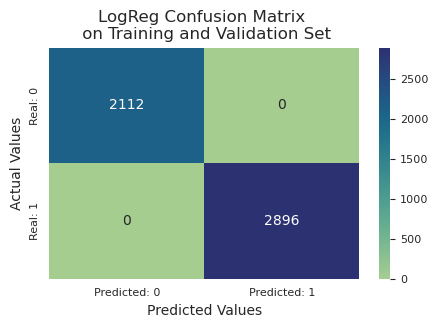

In [44]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='crest', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
plt.title('LogReg Confusion Matrix \n on Training and Validation Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Building a Decision Tree Classifier model and printing its confusion matrix:

In [45]:
treeclf = DecisionTreeClassifier(random_state=42)
treeclf.fit(X_train, y_train)
y_predict = cross_val_predict(treeclf, X_val, y_val, cv=3)
cm_treeclf = confusion_matrix(y_val, y_predict)
cm_treeclf

array([[2112,    0],
       [   0, 2896]])

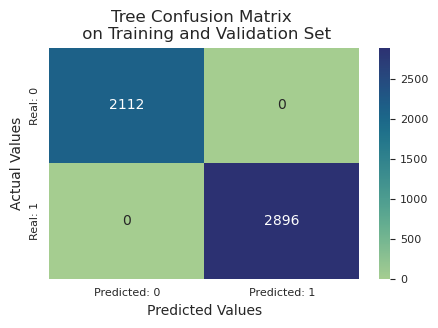

In [46]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm_treeclf, annot=True, fmt='d', cmap='crest', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
plt.title('Tree Confusion Matrix \n on Training and Validation Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 4. Evaluating the models

We repeat the procedure using the test set.

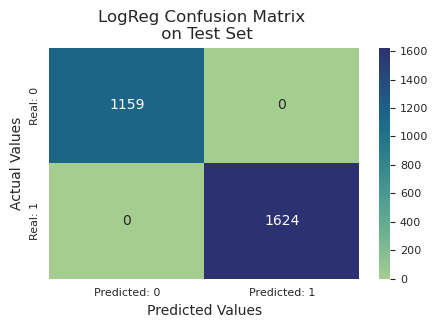

In [47]:
logreg = LogisticRegression(random_state=42, max_iter=1100)
logreg.fit(X_new, y_new)
y_predict = cross_val_predict(logreg, X_test, y_test, cv=3)
cm_logreg = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(5, 3))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='crest', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
plt.title('LogReg Confusion Matrix \n on Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

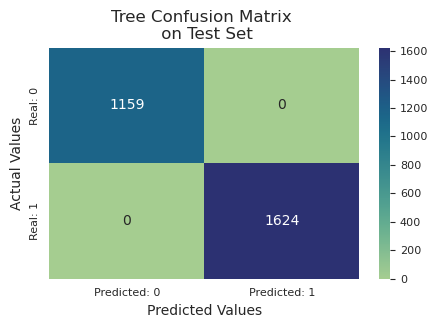

In [48]:
treeclf = DecisionTreeClassifier(random_state=42)
treeclf.fit(X_new, y_new)
y_predict = cross_val_predict(treeclf, X_test, y_test, cv=3)
cm_treeclf = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(5, 3))
sns.heatmap(cm_treeclf, annot=True, fmt='d', cmap='crest', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
plt.title('Tree Confusion Matrix \n on Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Both our models predict our target feature with perfect accuracy! What just happened?

Clearly, this would not have happened with a real dataset. The reason both models can predict the values with perfect accuracy is that the dataset has been artificially created. The instances have been created by specifying certain rules, and both models can detect them easily, even without cross validation.

With a real dataset, we would have already spotted differences when predicting values in the validation set. What would we have done in this case? First, we would have tuned both model parameters, then we would have selected the best-performing models according to our performance measure, trained it on both the training and validation set, and measured its performance on the test set.